## Trabalho Parte 2 - Alunas: Ainhoa Acinas Amparo Báguena

Primeiro, carregamos as bibliotecas que usaremos ao longo do código.

In [3]:
import os
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

O banco de dados  "17 Flores " contém imagens de flores de 17 categorias diferentes, com 80 imagens por categoria. As imagens foram obtidas pesquisando na web e tirando fotos. O arquivo  "datasplits.mat " especifica as divisões de dados usadas no artigo de Nilsback e Zisserman (2006) para a classificação de flores. Este arquivo contém três divisões (splits) de dados, cada uma com um arquivo de treinamento (trn1, trn2, trn3), validação (val1, val2, val3) e teste (tst1, tst2 ou tst3). 

Começamos definindo o caminho para esses dois arquivos, para que possamos trabalhar com eles.

Link datos: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/


In [4]:
# Ruta de las carpetas
data_dir = "C:/Users/ainho/Documents/UTAD/DeepLearning/TrabalhoParte2_AinhoaAcinasAmparoBaguena/Datos/17flowers"
split_file = "C:/Users/ainho/Documents/UTAD/DeepLearning/TrabalhoParte2_AinhoaAcinasAmparoBaguena/Datos/datasplits.mat"


Este fragmento de código carrega as divisões dos dados (treinamento, validação e teste) a partir de um arquivo . mat usando scipy.io.loadmat(). Como índices no MATLAB começam em 1, eles são ajustados subtraindo 1 a cada índice para que sejam compatíveis com o Python. Então todas as imagens são obtidas em formato . jpg do diretório especificado, gerando uma lista de caminhos completos para os arquivos em ordem alfabética. Essas etapas preparam os dados para uso posterior no modelo, garantindo que as imagens e índices de divisão estejam corretamente alinhados.

In [5]:
# Cargar las divisiones
data_splits = scipy.io.loadmat(split_file)
train_idx = data_splits['trn1'][0] - 1  # Los índices en Matlab empiezan en 1
val_idx = data_splits['val1'][0] - 1
test_idx = data_splits['tst1'][0] - 1

# Obtener todas las imágenes
image_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".jpg")])


Este código realiza duas tarefas principais. Primeiro, divide as imagens em três conjuntos (treinamento, validação e teste) usando os índices pré-carregados. Para cada conjunto, selecionamos os arquivos de imagem correspondentes através da compreensão de listas, atribuindo a train_files, val_files e test_files as imagens que correspondem a cada divisão. 

Em segundo lugar, cria um dicionário chamado categories, que atribui a cada número de 0 a 16 uma etiqueta em forma de cadeia com o formato  "Category X ", onde X é o número da categoria. O dicionário tem 17 chaves (de 0 a 16), cada uma representando uma categoria diferente. 

Esse dicionário pode ser usado mais tarde para rotular as imagens em cada conjunto de acordo com suas categorias.

In [6]:
# Dividir las imágenes según los splits
train_files = [image_files[i] for i in train_idx]
val_files = [image_files[i] for i in val_idx]
test_files = [image_files[i] for i in test_idx]

# Crear un diccionario para asignar etiquetas (0-16)
categories = {i: f"Category {i}" for i in range(0, 17)}

print(categories)

{0: 'Category 0', 1: 'Category 1', 2: 'Category 2', 3: 'Category 3', 4: 'Category 4', 5: 'Category 5', 6: 'Category 6', 7: 'Category 7', 8: 'Category 8', 9: 'Category 9', 10: 'Category 10', 11: 'Category 11', 12: 'Category 12', 13: 'Category 13', 14: 'Category 14', 15: 'Category 15', 16: 'Category 16'}


O código processa as imagens de forma eficiente, etiqueta-as com base no índice e organiza-as em lotes para serem alimentadas ao modelo. Além disso, garante que as imagens tenham o tamanho adequado para o modelo e normaliza os valores de pixel.

In [7]:
# Preprocesamiento: Generadores de imágenes
def preprocess_dataset(file_paths, labels, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x), channels=3), target_size), y))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

#Etiquetas
train_labels = [int(i // 80) for i in train_idx]  # Rango 0-16
val_labels = [int(i // 80) for i in val_idx]
test_labels = [int(i // 80) for i in test_idx]

Prepara os três conjuntos de dados para serem usados no modelo, garantindo que as imagens sejam adequadamente pré-processadas, carregadas em lotes e otimizadas para uso durante o treinamento e avaliação.

In [8]:
# Crear datasets
train_ds = preprocess_dataset(train_files, train_labels)
val_ds = preprocess_dataset(val_files, val_labels)
test_ds = preprocess_dataset(test_files, test_labels)


Este código usa o ResNet50 pré-treinado como um extrato de recursos, e adiciona camadas adicionais para se adequar a um problema de classificação multiclase com 17 categorias. O modelo é congelado na base e otimizado usando o otimizador Adam, configurando a perda como sparse_categorical_crossentropy e a métrica de avaliação como accuracy.

In [9]:
# Modelo: Usar ResNet50 preentrenado
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar pesos

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(17, activation="softmax")  # 17 categorías
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])



Treinamos o modelo com as imagens de treinamento

In [10]:
# Entrenamiento
history = model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.0329 - loss: 6.4803 - val_accuracy: 0.1353 - val_loss: 2.8845
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.0900 - loss: 3.7696 - val_accuracy: 0.4765 - val_loss: 2.1694
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.2947 - loss: 2.2727 - val_accuracy: 0.6206 - val_loss: 1.7253
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.4238 - loss: 1.9347 - val_accuracy: 0.7412 - val_loss: 1.3654
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5438 - loss: 1.5160 - val_accuracy: 0.7824 - val_loss: 1.0794
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.6187 - loss: 1.3430 - val_accuracy: 0.8265 - val_loss: 0.8597
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.6810 - loss: 1.0697 - val_accuracy: 0.8441 - val_loss: 0.7448
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.7352 - loss: 0.9079 - val_accuracy: 0.8471 - val_loss

Durante o treinamento do modelo, há uma melhoria constante na precisão e redução da perda ao longo dos 10 tempos. No início, a precisão é baixa, tanto no conjunto de treinamento (3,29% aprox) como no conjunto de validação (13,53% aprox), o que é esperado. No entanto, à medida que as eras avançam, o modelo começa a aprender melhor, com uma precisão no conjunto de treinamento que atinge 82,12% na última época e uma precisão de validação que melhora até 86,47% aprox. A perda também diminui consistentemente, indicando que o modelo está ajustando adequadamente seus parâmetros. Estes resultados sugerem que o modelo está aprendendo a classificar corretamente as 17 categorias sem superajuste, alcançando um bom desempenho no conjunto de validação.

Después de completar el entrenamiento, el modelo se evalúa utilizando el conjunto de datos de prueba (test_ds).

In [11]:
# Evaluación
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8676 - loss: 0.4462
Test Accuracy: 0.88


Os resultados mostram uma precisão de teste de 86,76% aprox e uma perda de 0,4462 aprox. Finalmente, o valor da precisão do teste é impresso como 88% aprox. Estes resultados indicam que o modelo tem um bom desempenho geral no conjunto de teste, alcançando uma precisão bastante alta, sugerindo que aprendeu a generalizar bem para novos dados não vistos durante o treinamento e validação.

Após a previsão do conjunto de testes, o relatório de classificação é calculado, que inclui métricas como precisão, lembrete e f1-score para cada uma das 17 categorias.

In [12]:
# Predicción y métricas
y_pred = np.argmax(model.predict(test_ds), axis=-1)
print(classification_report(test_labels, y_pred, target_names=[categories[i] for i in range(0, 17)]))


11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step
              precision    recall  f1-score   support

  Category 0       0.83      0.75      0.79        20
  Category 1       0.78      0.90      0.84        20
  Category 2       0.95      0.90      0.92        20
  Category 3       0.95      0.90      0.92        20
  Category 4       0.89      0.80      0.84        20
  Category 5       0.95      0.90      0.92        20
  Category 6       0.90      0.90      0.90        20
  Category 7       0.61      0.70      0.65        20
  Category 8       0.90      0.95      0.93        20
  Category 9       1.00      1.00      1.00        20
 Category 10       1.00      1.00      1.00        20
 Category 11       0.91      1.00      0.95        20
 Category 12       1.00      0.80      0.89        20
 Category 13       0.75      0.75      0.75        20
 Category 14       0.94      0.80      0.86        20
 Category 15       0.95      0.95      0.95        20
 Category 16       0.80      1.00      0.8

O relatório de classificação obtido após a realização da previsão sobre o conjunto de teste mostra que o modelo tem um bom desempenho geral, com uma precisão de 88% aproximadamente. A precisão das diferentes categorias varia, chegando a valores próximos de 1,0 em categorias como 9, 10, 11 e 12, o que indica que o modelo faz previsões muito acertadas nestas classes. A lembrança também é alta para muitas categorias, especialmente nas categorias 9 e 10, onde o modelo tem uma lembrança de 100%. No entanto, em algumas categorias, como 7, a lembrança é menor (70%), o que sugere que o modelo tem mais dificuldade para prever corretamente essas classes. O f1-score, que combina precisão e lembrança, também mostra bons resultados, com valores próximos a 1,0 na maioria das categorias. Em resumo, o modelo tem um bom desempenho global, mas algumas categorias, como a categoria 7, poderiam beneficiar de mais dados ou ajustes específicos para melhorar sua precisão e lembrança.

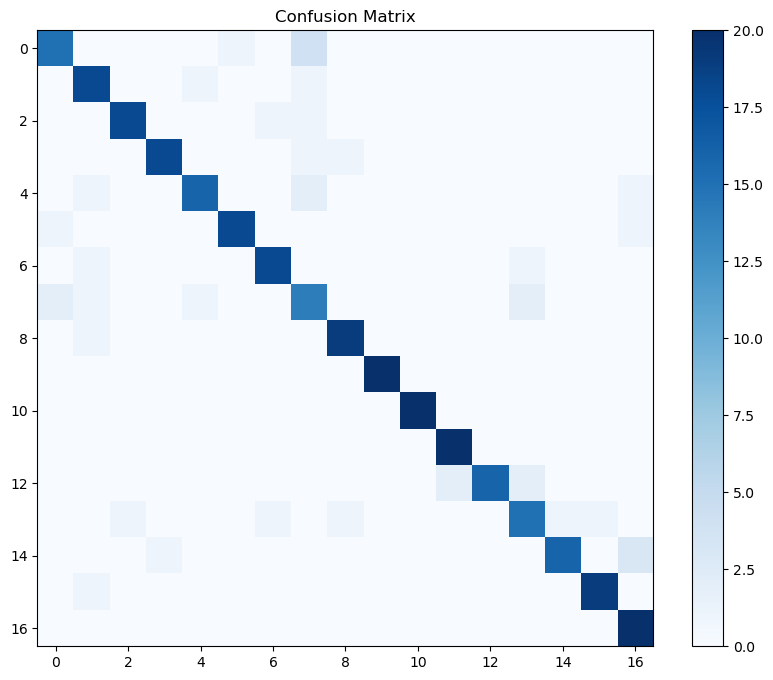

In [13]:
# Matriz de confusión
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.show()

Cada linha representa as verdadeiras etiquetas (labels) e cada coluna mostra as previsões do modelo. Na diagonal principal estão os valores mais altos, indicando que o modelo classificou corretamente a maioria das instâncias de cada categoria. Os valores mais baixos fora da diagonal refletem os casos em que o modelo cometeu erros de classificação, embora em geral, parece que o modelo tem um bom desempenho com uma alta concentração de valores na diagonal, o que é consistente com as métricas acima. 

O mapa de cores destaca a quantidade de vezes que uma previsão foi feita para cada classe, mostrando que algumas categorias têm mais instâncias corretamente predichas, enquanto outras, como categoria 7, parecem ter mais erros. No entanto, a maioria das categorias tem uma distribuição bastante precisa ao longo da diagonal.